<a href="https://colab.research.google.com/github/JonatasLemos/DataAnalysisProjects/blob/main/altitudesAnalysis/MunicipalAltitudePart1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Altitude Analysis

In [ ]:
pip install simpledbf

In [ ]:
pip install unidecode

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from simpledbf import Dbf5 as db
from unidecode import unidecode
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Reading dbf 

In [ ]:
path_start ="/content/drive/MyDrive/Colab Data/"
dbf = db(f"{path_start}ZonalSt_alt_municip.dbf")
df_altitudes = dbf.to_dataframe()
df_altitudes.head()

,NM_MUN,ZONE_CODE,COUNT,AREA,MIN,MAX,RANGE,MEAN,STD,SUM,VARIETY,MAJORITY,MINORITY,MEDIAN
0,Abadia dos Dourados,1,1092,0.075833,639,988,349,772.872711,61.986597,843977.0,270,760,639,774
1,Abaeté,2,2245,0.155903,564,904,340,642.046771,43.834646,1441395.0,223,632,717,637
2,Abre Campo,3,581,0.040347,391,1068,677,672.084337,126.220764,390481.0,345,642,391,669
3,Acaiaca,4,123,0.008542,450,744,294,609.121951,60.718005,74922.0,96,606,450,617
4,Açucena,5,1007,0.069931,197,964,767,502.974181,201.501221,506495.0,515,243,197,492


In [ ]:
df_altitudes.drop(['ZONE_CODE', 'COUNT','MAJORITY','MINORITY'], axis=1,inplace=True)
df_altitudes.rename(columns={"NM_MUN": "NAME"},inplace=True)
df_altitudes["NAME_UNIDECODE"] = df_altitudes["NAME"].str.lower().apply(unidecode)
df_altitudes[["MEAN","STD"]] = df_altitudes[["MEAN","STD"]].apply(np.round)
df_altitudes["AREA"] = df_altitudes["AREA"].apply(lambda x:np.round(x,3))
df_altitudes.to_csv(f"{path_start}altitudes.csv",index=False)
df_altitudes.head(3)

,NAME,AREA,MIN,MAX,RANGE,MEAN,STD,SUM,VARIETY,MEDIAN,NAME_UNIDECODE
0,Abadia dos Dourados,0.076,639,988,349,773.0,62.0,843977.0,270,774,abadia dos dourados
1,Abaeté,0.156,564,904,340,642.0,44.0,1441395.0,223,637,abaete
2,Abre Campo,0.040,391,1068,677,672.0,126.0,390481.0,345,669,abre campo


## Using Pearson Correlation and Visualizing MEAN Altitude Column

In [ ]:
print("CORRELATION BETWEEN MEAN MUNICIPAL ALTITUDE AND MUNICIPAL ALTITUDE RANGE")
corr,pval=stats.pearsonr(df_altitudes['MEAN'],df_altitudes['RANGE'])
print(f"Correlation:{corr: .3f}")
print(f"P-VALUE:{pval: .5f}")

CORRELATION BETWEEN MEAN MUNICIPAL ALTITUDE AND MUNICIPAL ALTITUDE RANGE
Correlation: 0.202
P-VALUE: 0.00000


Text(0.5, 1.0, 'Boxplot Altitude Média Municipal (m)')

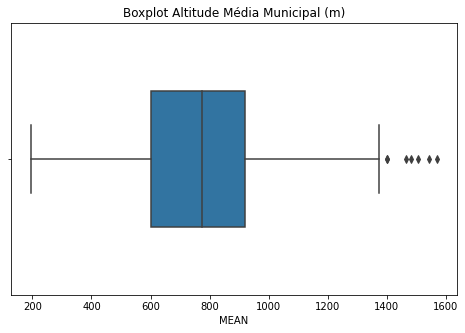

In [ ]:
ax = sns.boxplot(x=df_altitudes["MEAN"],width=0.5)
ax.set_title('Boxplot Altitude Média Municipal (m)')

In [ ]:
central_tendency = (np.mean(df_altitudes["MEAN"]),np.median(df_altitudes["MEAN"]))
print(f"The mean of mean municipal altitudes is: {round(central_tendency[0],2)}")
print(f"The median of mean municipal altitudes is: {central_tendency[1]}")

The mean of mean municipal altitudes is: 762.76
The median of mean municipal altitudes is: 776.0


Text(0.5, 1.0, 'Frequência Altitude Média Municipal (m)')

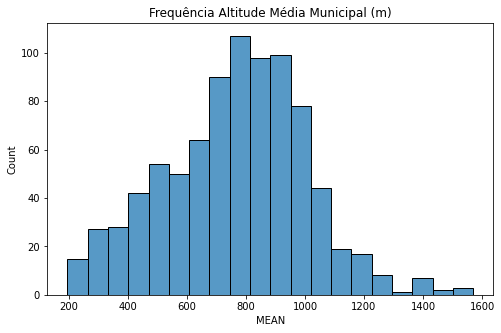

In [ ]:
ax = sns.histplot(data=df_altitudes, x="MEAN",bins=20)
ax.set_title('Frequência Altitude Média Municipal (m)')

## Hypothesis testing - Is it a normal distribution?

In [ ]:
alpha = 5e-2

In [ ]:
k2, p = stats.normaltest(df_altitudes["MEAN"])
isNormal = p < alpha
print(f"The null hypothesis is {isNormal}")

The null hypothesis is False


## Creating intervals of altitudes using pd.cut

In [ ]:
df_altitudes.sort_values(by="NAME_UNIDECODE",inplace=True)
df_altitudes["ALTITUDE"] = pd.cut(x=df_altitudes["MEAN"],bins=[0, 300, 600, 850, 1100, 1600]
                    ,labels=["0-300m","300-600m","600-850m","850-1100m","1100-1600m"])
df_altitudes[["NAME","MEAN","ALTITUDE"]].tail()

,NAME,MEAN,ALTITUDE
848,Virginópolis,811.0,600-850m
849,Virgolândia,504.0,300-600m
850,Visconde do Rio Branco,411.0,300-600m
851,Volta Grande,279.0,0-300m
852,Wenceslau Braz,1216.0,1100-1600m


## Finding the number of cities in each interval

In [ ]:
porcentagem = round((df_altitudes["ALTITUDE"].value_counts(normalize=True))*100,2)
frequencia = df_altitudes["ALTITUDE"].value_counts()
df_stats = pd.DataFrame({"%":porcentagem,"frequencia":frequencia})
df_stats

,%,frequencia
600-850m,38.34,327
850-1100m,31.18,266
300-600m,21.45,183
1100-1600m,5.74,49
0-300m,3.28,28


## Creating population Dataframe from xls

In [ ]:
df_population = pd.read_excel(f"{path_start}population.xls", sheet_name="Municípios")
df_population.dropna(inplace=True)
df_pop = df_population.copy()
df_pop = df_pop[df_pop["UF"] == "MG"]
df_pop.reset_index(inplace=True,drop=True)
df_pop.drop(['UF', 'COD. UF','COD. MUNIC'], axis=1,inplace=True)
df_pop["NAME_UNIDECODE"] = df_pop["NOME DO MUNICÍPIO"].str.lower().apply(unidecode)
df_pop.sort_values(by="NAME_UNIDECODE",inplace=True)
df_pop.tail()

,NOME DO MUNICÍPIO,POPULAÇÃO ESTIMADA,NAME_UNIDECODE
848,Virginópolis,10810.0,virginopolis
849,Virgolândia,5664.0,virgolandia
850,Visconde do Rio Branco,41182.0,visconde do rio branco
851,Volta Grande,5288.0,volta grande
852,Wenceslau Braz,2617.0,wenceslau braz


## Correcting wrong names

In [ ]:
wrong_names = df_altitudes[~df_altitudes['NAME'].
    isin(df_pop['NOME DO MUNICÍPIO'])]["NAME"].to_numpy()
correct_names = df_pop[~df_pop['NOME DO MUNICÍPIO'].
    isin(df_altitudes['NAME'])]['NOME DO MUNICÍPIO'].to_numpy()
correct_names    

array(['Brasópolis', 'Dona Eusébia', 'Passa-Vinte', "Pingo-d'Água",
       'São Sebastião da Vargem Alegre', 'São Thomé das Letras'],
      dtype=object)

In [ ]:
df_altitudes['NAME'].replace(wrong_names,correct_names,inplace=True)

## Merging DFs

In [ ]:
df_altitudes = df_altitudes.merge(df_pop)
df_altitudes.drop(["NAME"],axis=1,inplace=True)
df_altitudes[["NOME DO MUNICÍPIO","MEAN","ALTITUDE","POPULAÇÃO ESTIMADA"]].head()

,NOME DO MUNICÍPIO,MEAN,ALTITUDE,POPULAÇÃO ESTIMADA
0,Abadia dos Dourados,773.0,600-850m,7015.0
1,Abaeté,642.0,600-850m,23535.0
2,Abre Campo,672.0,600-850m,13719.0
3,Acaiaca,609.0,600-850m,4056.0
4,Açucena,503.0,300-600m,10140.0


In [ ]:
df_altitudes["CATEGORIA CIDADE"] = pd.cut(x=df_altitudes["POPULAÇÃO ESTIMADA"],bins=[0,50000,100000,3000000]
                    ,labels=["pequena","média","grande"])
crosstab = pd.crosstab(df_altitudes["ALTITUDE"],
                         df_altitudes["CATEGORIA CIDADE"],
                         aggfunc = 'mean',
                         values = df_altitudes["POPULAÇÃO ESTIMADA"])
crosstab = crosstab.round(0)

In [ ]:
print("POPULAÇÃO MÉDIA POR FAIXA DE CIDADE")
crosstab

POPULAÇÃO MÉDIA POR FAIXA DE CIDADE


CATEGORIA CIDADE,pequena,média,grande
ALTITUDE,,,
0-300m,9500.0,NaN,278363.0
300-600m,10504.0,64524.0,144000.0
600-850m,11197.0,75093.0,277352.0
850-1100m,12253.0,73612.0,389169.0
1100-1600m,9068.0,81968.0,163677.0


## Generating CSV with altitude intervals


In [ ]:
df_altitudes_csv = df_altitudes.set_index(["ALTITUDE","NOME DO MUNICÍPIO"])
df_altitudes_csv.sort_values(by="MEAN",inplace=True)
df_altitudes_csv.to_csv(f"{path_start}altitude_intervals.csv",index=False)
df_altitudes_csv[["MEAN","POPULAÇÃO ESTIMADA"]]

MEAN  POPULAÇÃO ESTIMADA
ALTITUDE   NOME DO MUNICÍPIO                            
0-300m     Serra dos Aimorés   195.0              8767.0
           Pirapetinga         202.0             10818.0
           Salto da Divisa     217.0              7107.0
           Alpercata           219.0              7478.0
           Tumiritinga         230.0              6669.0
...                              ...                 ...
1100-1600m Senador Amaral     1465.0              5419.0
           Delfim Moreira     1483.0              8201.0
           Alagoa             1507.0              2760.0
           Marmelópolis       1544.0              2938.0
           Itamonte           1570.0             15136.0

[847 rows x 2 columns]

## Interval of Altitudes - Statistics


In [ ]:
grouped_altitudes = df_altitudes.groupby(["ALTITUDE"])["POPULAÇÃO ESTIMADA"].agg(["sum","mean","size"])
mg_total_pop = grouped_altitudes["sum"].sum()
grouped_altitudes["population_share"] = grouped_altitudes["sum"].apply(lambda x:(x/mg_total_pop)*100)
grouped_altitudes.sort_values(by="population_share",ascending=False)
grouped_altitudes[["sum","mean"]] = grouped_altitudes[["sum","mean"]].round(0)
grouped_altitudes["population_share"] = grouped_altitudes["population_share"].round(2)
grouped_altitudes

,sum,mean,size,population_share
ALTITUDE,,,,
0-300m,534873.0,19103.0,28,2.57
300-600m,3000834.0,16579.0,181,14.41
600-850m,8068629.0,24750.0,326,38.73
850-1100m,8481763.0,32250.0,263,40.72
1100-1600m,744722.0,15198.0,49,3.58


## Ploting Data

In [ ]:
title_font = 20
label_font = 14
plt.rcParams["figure.figsize"] = [9, 6]
def plot_bar(*args):
  plt.barh(args[0],args[1])
  plt.title(f'{args[2]} por faixa de altitude - Minas Gerais',fontsize=title_font)
  plt.xlabel(f'{args[2]}',fontsize=label_font)
  plt.ylabel('Altitude Média Municipal',fontsize=label_font)
  plt.xticks(fontsize=label_font)
  plt.yticks(fontsize=label_font)
  plt.grid(lw="0.2")
  plt.show()

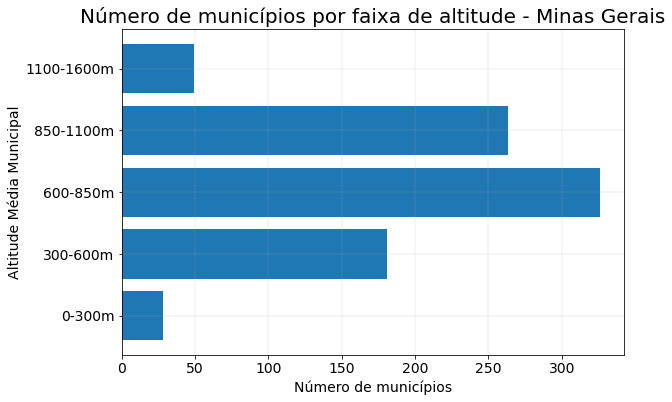

In [ ]:
plot_bar(grouped_altitudes.index,grouped_altitudes["size"],"Número de municípios")

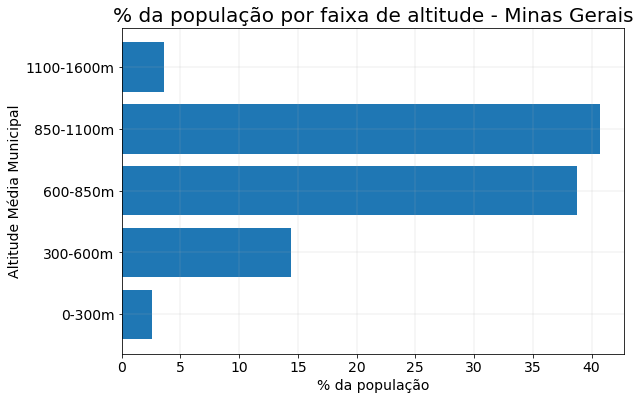

In [ ]:
plot_bar(grouped_altitudes.index,grouped_altitudes["population_share"],"% da população")